In [79]:
# Warning: Notebook can take around 5 minutes to run

In [1]:
import time
start_time = time.time()


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, \
    FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, \
    HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, classification_report, roc_auc_score, \
    plot_roc_curve, make_scorer, get_scorer

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

pd.options.display.max_columns = None
seed = 50

**Reading in the dataset**. This is from an online competition on DrivenData, so the provided test set doesn't have labels. For this reason I'll treat the provided training set and labels as a the whole dataset, on which I will later peform a train-test split.

In [2]:
features = pd.read_csv('data/training_set_features.csv')
target = pd.read_csv('data/training_set_labels.csv')

In [3]:
data = pd.concat([features, target], axis=1)

In [4]:
data = data.drop(columns=['respondent_id', 'seasonal_vaccine'])

In [5]:
data.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [7]:
(data.isna().sum() / len(data)) * 100

h1n1_concern                    0.344479
h1n1_knowledge                  0.434343
behavioral_antiviral_meds       0.265848
behavioral_avoidance            0.778822
behavioral_face_mask            0.071142
behavioral_wash_hands           0.157262
behavioral_large_gatherings     0.325757
behavioral_outside_home         0.307036
behavioral_touch_face           0.479275
doctor_recc_h1n1                8.087767
doctor_recc_seasonal            8.087767
chronic_med_condition           3.635751
child_under_6_months            3.070356
health_worker                   3.010447
health_insurance               45.957989
opinion_h1n1_vacc_effective     1.464036
opinion_h1n1_risk               1.452803
opinion_h1n1_sick_from_vacc     1.479013
opinion_seas_vacc_effective     1.729884
opinion_seas_risk               1.924589
opinion_seas_sick_from_vacc     2.010709
age_group                       0.000000
education                       5.268282
race                            0.000000
sex             

#### Observations:
There are several features with a large amount of data missing. I'll have to decide if I should impute them with some value or drop them. 

In particular, `health_insurance` has 46% of its data missing, but I would rather not drop that whole feature because it seems pertinent to the matter of taking an H1N1 vaccine. 

`employment_industry` and `employment_occupation` have half their data missing. The values are encoded in an odd way and are not interpretable, so I'll drop these columns.

In [8]:
X = data.drop(columns=['h1n1_vaccine', 'employment_industry', 'employment_occupation'])
y = data['h1n1_vaccine']

#### Train-test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

In [10]:
# Separate numerical and object columns in order to use different imputing strategies

X_train_num = X_train.select_dtypes('number')
X_train_obj = X_train.select_dtypes('object')

# Encoding object columns with numbers

ord_encoder = OrdinalEncoder()
X_train_obj = pd.DataFrame(ord_encoder.fit_transform(X_train_obj), columns=X_train_obj.columns, index=X_train_obj.index)

#### Imputing all missing values with the mean or most nearest neighbor

In [11]:
num_imputer = SimpleImputer(strategy='mean')
obj_imputer = KNNImputer()

In [12]:
# Imputing missing numerical values with the mean from that column
imputed_x_train_num = pd.DataFrame(num_imputer.fit_transform(X_train_num), columns=X_train_num.columns, index=X_train_num.index)

# Imputing missing numerical values with the nearest neighbor
imputed_x_train_obj = obj_imputer.fit_transform(X_train_obj)

# Undoing the ordinal encoding, in order to one-hot encode
imputed_x_train_obj = pd.DataFrame(ord_encoder.inverse_transform(imputed_x_train_obj), columns=X_train_obj.columns, index=X_train_obj.index)

# Combining the numerical and object data
X_train_imp = pd.concat(
    [
       imputed_x_train_num,
       imputed_x_train_obj
    ],
    axis=1
)

In [13]:
X_train_imp.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa
16087,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.000000,5.0,2.0,4.0,5.0,2.0,1.0,2.0,0.0,18 - 34 Years,Some College,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,oxchjgsf,"MSA, Principle City"
9261,2.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.880081,5.0,2.0,4.0,5.0,4.0,1.0,1.0,0.0,65+ Years,College Graduate,White,Male,"> $75,000",Married,Own,Employed,bhuqouqj,Non-MSA
16193,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.880081,5.0,2.0,2.0,5.0,4.0,2.0,0.0,2.0,45 - 54 Years,College Graduate,White,Female,"<= $75,000, Above Poverty",Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City"
18216,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.880081,4.0,4.0,4.0,5.0,2.0,1.0,0.0,0.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Rent,Employed,dqpwygqj,"MSA, Principle City"
9161,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,5.0,4.0,1.0,5.0,5.0,1.0,1.0,0.0,55 - 64 Years,12 Years,White,Male,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City"


No more missing values

In [14]:
X_train_imp.isna().sum()

h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
health_insurance               0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
household_adults               0
household_children             0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment

#### One-hot encoding and scaling

In [15]:
X_train_ohe = pd.get_dummies(X_train_imp)

In [16]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_ohe), columns=X_train_ohe.columns, index=X_train_ohe.index)

In [17]:
X_train_scaled.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_< 12 Years,education_College Graduate,education_Some College,race_Black,race_Hispanic,race_Other or Multiple,race_White,sex_Female,sex_Male,"income_poverty_<= $75,000, Above Poverty","income_poverty_> $75,000",income_poverty_Below Poverty,marital_status_Married,marital_status_Not Married,rent_or_own_Own,rent_or_own_Rent,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA
16087,-0.675263,-0.423433,-0.226876,0.613266,-0.271729,0.457501,-0.748773,-0.718063,0.687215,-0.550405,-0.726445,1.615694,-0.302783,-0.361247,5.027249e-01,1.144717,-0.268425,1.218449,0.901472,-0.525359,-0.846847,1.476925,-0.577187,2.011619,-0.409959,-0.491873,-0.513151,-0.584614,-0.530961,-0.361056,-0.819472,1.673978,-0.293341,-0.265721,-0.253896,0.508956,0.824503,-0.824503,-1.273740,-0.620491,2.945561,-1.114674,1.114674,-1.870318,1.870318,-1.109285,1.243024,-0.242215,-0.285234,-0.347578,-0.207916,-0.375221,-0.347036,-0.287784,-0.440498,-0.301889,2.911173,-0.363260,-0.883607,1.549040,-0.604152
9261,0.422204,1.197152,-0.226876,0.613266,-0.271729,0.457501,1.339799,1.397240,0.687215,-0.550405,1.494290,-0.642439,-0.302783,-0.361247,4.654300e-16,1.144717,-0.268425,1.218449,0.901472,0.935203,-0.846847,0.147572,-0.577187,-0.497112,-0.409959,-0.491873,-0.513151,1.710530,-0.530961,-0.361056,1.220298,-0.597379,-0.293341,-0.265721,-0.253896,0.508956,-1.212852,1.212852,-1.273740,1.611627,-0.339494,0.897123,-0.897123,0.534668,-0.534668,0.901482,-0.804490,-0.242215,-0.285234,2.877055,-0.207916,-0.375221,-0.347036,-0.287784,-0.440498,-0.301889,-0.343504,-0.363260,-0.883607,-0.645561,1.655213
16193,0.422204,1.197152,-0.226876,0.613266,-0.271729,0.457501,-0.748773,-0.718063,0.687215,1.972218,1.494290,1.615694,-0.302783,-0.361247,4.654300e-16,1.144717,-0.268425,-0.263629,0.901472,0.935203,-0.088790,-1.181781,1.596300,-0.497112,-0.409959,2.033043,-0.513151,-0.584614,-0.530961,-0.361056,1.220298,-0.597379,-0.293341,-0.265721,-0.253896,0.508956,0.824503,-0.824503,0.785089,-0.620491,-0.339494,-1.114674,1.114674,-1.870318,1.870318,0.901482,-0.804490,-0.242215,-0.285234,2.877055,-0.207916,-0.375221,-0.347036,-0.287784,-0.440498,-0.301889,-0.343504,-0.363260,1.131725,-0.645561,-0.604152
18216,-0.675263,-0.423433,-0.226876,-1.643744,-0.271729,0.457501,-0.748773,-0.718063,-1.462084,-0.550405,1.494290,-0.642439,-0.302783,2.854550,4.654300e-16,0.148336,1.299229,1.218449,0.901472,-0.525359,-0.846847,-1.181781,-0.577187,-0.497112,-0.409959,2.033043,-0.513151,-0.584614,-0.530961,-0.361056,-0.819472,1.673978,-0.293341,-0.265721,-0.253896,0.508956,0.824503,-0.824503,0.785089,-0.620491,-0.339494,-1.114674,1.114674,-1.870318,1.870318,0.901482,-0.804490,-0.242215,-0.285234,-0.347578,4.809629,-0.375221,-0.347036,-0.287784,-0.440498,-0.301889,-0.343504,-0.363260,-0.883607,1.549040,-0.604152
9161,0.422204,-0.423433,-0.226876,0.613266,-0.271729,0.457501,-0.748773,-0.718063,0.687215,-0.550405,-0.726445,-0.642439,-0.302783,-0.361247,5.027249e-01,1.144717,1.299229,-1.004668,0.901472,1.665484,-0.846847,0.147572,-0.57718

#### Applying preprocessing steps to test set

In [18]:
X_test_num = X_test.select_dtypes('number')
X_test_obj = X_test.select_dtypes('object')
X_test_obj = pd.DataFrame(ord_encoder.transform(X_test_obj), columns=X_test_obj.columns, index=X_test_obj.index)

# Imputing missing numerical values with the mean from that column
imputed_x_test_num = pd.DataFrame(num_imputer.transform(X_test_num), columns=X_test_num.columns, index=X_test_num.index)

# Imputing missing numerical values with the nearest neighbor
imputed_x_test_obj = obj_imputer.transform(X_test_obj)

# Undoing the ordinal encoding, in order to one-hot encode
imputed_x_test_obj = pd.DataFrame(ord_encoder.inverse_transform(imputed_x_test_obj), columns=X_test_obj.columns, index=X_test_obj.index)

# Combining the numerical and object data
X_test_imp = pd.concat(
    [
       imputed_x_test_num,
       imputed_x_test_obj
    ],
    axis=1
)

X_test_ohe = pd.get_dummies(X_test_imp)

X_test_scaled = pd.DataFrame(scaler.transform(X_test_ohe), columns=X_test_ohe.columns, index=X_test_ohe.index)

In [19]:
X_test_scaled.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_< 12 Years,education_College Graduate,education_Some College,race_Black,race_Hispanic,race_Other or Multiple,race_White,sex_Female,sex_Male,"income_poverty_<= $75,000, Above Poverty","income_poverty_> $75,000",income_poverty_Below Poverty,marital_status_Married,marital_status_Not Married,rent_or_own_Own,rent_or_own_Rent,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA
20463,1.519672,-0.423433,-0.226876,-1.643744,3.683263,0.457501,1.339799,1.397240,6.872148e-01,1.972218,1.494290,-0.642439,-0.302783,-0.361247,4.654300e-16,-1.844427,1.299229e+00,1.959488,0.901472,1.665484,-0.846847,0.147572,1.596300,2.011619,-0.409959,-0.491873,-0.513151,-0.584614,-0.530961,-0.361056,-0.819472,1.673978,-0.293341,-0.265721,3.938626,-1.964808,0.824503,-0.824503,0.785089,-0.620491,-0.339494,-1.114674,1.114674,-1.870318,1.870318,0.901482,-0.804490,-0.242215,-0.285234,-0.347578,-0.207916,-0.375221,-0.347036,-0.287784,-0.440498,3.312477,-0.343504,-0.363260,1.131725,-0.645561,-0.604152
14057,-0.675263,-2.044018,-0.226876,-1.643744,-0.271729,-2.189176,-0.748773,-0.718063,-1.462084e+00,1.972218,1.494290,1.615694,-0.302783,-0.361247,5.027249e-01,-0.848045,-3.480893e-16,-1.004668,0.901472,-1.255640,-0.846847,0.147572,-0.577187,-0.497112,-0.409959,-0.491873,-0.513151,1.710530,1.883376,-0.361056,-0.819472,-0.597379,-0.293341,-0.265721,-0.253896,0.508956,0.824503,-0.824503,0.785089,-0.620491,-0.339494,-1.114674,1.114674,0.534668,-0.534668,-1.109285,1.243024,-0.242215,-0.285234,-0.347578,-0.207916,2.665099,-0.347036,-0.287784,-0.440498,-0.301889,-0.343504,-0.363260,-0.883607,-0.645561,1.655213
8372,0.422204,-0.423433,-0.226876,0.613266,-0.271729,0.457501,-0.748773,-0.718063,6.872148e-01,-0.550405,-0.726445,-0.642439,-0.302783,-0.361247,-3.689496e+00,0.148336,1.299229e+00,1.218449,-0.025097,0.935203,1.427325,0.147572,2.683044,2.011619,-0.409959,-0.491873,-0.513151,-0.584614,1.883376,-0.361056,-0.819472,-0.597379,-0.293341,-0.265721,3.938626,-1.964808,-1.212852,1.212852,0.785089,-0.620491,-0.339494,-1.114674,1.114674,-1.870318,1.870318,0.901482,-0.804490,-0.242215,-0.285234,-0.347578,-0.207916,-0.375221,2.881544,-0.287784,-0.440498,-0.301889,-0.343504,-0.363260,1.131725,-0.645561,-0.604152
21740,-1.772730,-0.423433,0.000000,0.000000,-0.271729,0.457501,-0.748773,-0.718063,2.386201e-16,-0.550405,1.494290,1.615694,-0.302783,-0.361247,5.027249e-01,-0.848045,5.154020e-01,-1.004668,0.901472,-0.525359,-0.846847,-1.181781,-0.577187,-0.497112,-0.409959,-0.491873,-0.513151,1.710530,-0.530961,-0.361056,-0.819472,1.673978,-0.293341,-0.265721,-0.253896,0.508956,0.824503,-0.824503,0.785089,-0.620491,-0.339494,-1.114674,1.114674,-1.870318,1.870318,-1.109285,1.243024,-0.242215,-0.285234,-0.347578,-0.207916,-0.375221,-0.347036,-0.287784,-0.440498,-0.301889,-0.343504,2.752846,-0.883607,-0.645561,1.655213
15147,0.422204,-0.423433,-0.226876,0.613266,-0.271729,0.457501,1.339799,-0.718063,-1.462084e+00,0.000000,0.000000,-0.642439,-0.302783,2.854550,4.654300e-16,0.148336,-2.684253e-01,1.218449,0.90

#### A function to show various metrics for a given fitted model

In [20]:
# A function that shows training and cross-validated scores for a fitted model.
def model_cv_results(estimator, X, y_true, metrics=['accuracy', 'roc_auc'], cv=True, k=5):
    """
    Returns a DataFrame with training scores and mean cross validation scores for a model.
    The function is preset to return scores for accuracy and roc_auc.
    If running this function on a test set, cv should be set to False.
    This function can often take a few minutes to run.
    """
    all_train_scores = []
    all_cv_scores = []
    
    for m in metrics:
        scorer = get_scorer(m)
        train_score = scorer(estimator, X, y_true)
        all_train_scores.append(train_score)
    
    if cv:
        cv_results = cross_validate(estimator, X, y_true, scoring=metrics, cv=k)
        for m in metrics:
            mean_cv_score = np.mean(cv_results['test_' + m])
            all_cv_scores.append(mean_cv_score)

        df = pd.DataFrame(zip(all_train_scores, all_cv_scores), columns=['train_score', 'mean_cv_score'], index=metrics)
        return df
    else:
        df = pd.DataFrame(data=all_train_scores, index=metrics, columns=['score'])
        return df

## Modeling

### Vanilla Logistic Regression Model

In [21]:
logreg = LogisticRegression(random_state=seed)

In [22]:
logreg.fit(X_train_scaled, y_train)

LogisticRegression(random_state=50)

In [23]:
logreg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 50,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [24]:
logreg_results = model_cv_results(logreg, X_train_scaled, y_train)
logreg_results

,train_score,mean_cv_score
accuracy,0.838992,0.837993
roc_auc,0.839199,0.836371


In [25]:
# Making a function to keep track of all models and results in a single dictionary.

models_dict = {
    'models': {},
    'results': {}
}

def store_model(name, model, results, dictionary=models_dict):
    """
    Stores models and results for later use and comparison.
    """
    dictionary['models'][name] = model
    dictionary['results'][name] = results

In [26]:
store_model('logreg', logreg, logreg_results)

#### Grid Search on Logistic Regression

In [27]:
gs_scoring = 'roc_auc'

grid_logreg = {
    'solver':['lbfgs', 'liblinear'],
    'C': [1, 1e2, 1e5, 1e10],
    'fit_intercept': [True, False]
}

gs_logreg = GridSearchCV(
    estimator=logreg,
    param_grid=grid_logreg,
    cv=5,
    scoring=gs_scoring
)

In [28]:
gs_logreg.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=50),
             param_grid={'C': [1, 100.0, 100000.0, 10000000000.0],
                         'fit_intercept': [True, False],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='roc_auc')

In [29]:
gs_logreg.best_params_

{'C': 100.0, 'fit_intercept': True, 'solver': 'lbfgs'}

In [30]:
gs_logreg_results = model_cv_results(gs_logreg.best_estimator_, X_train_scaled, y_train)
gs_logreg_results

,train_score,mean_cv_score
accuracy,0.839041,0.837893
roc_auc,0.839198,0.836373


In [31]:
store_model('gs_logreg', gs_logreg.best_estimator_, gs_logreg_results)

### Random Forest Classifier

In [32]:
rfc = RandomForestClassifier(random_state=seed)

In [33]:
rfc.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=50)

In [34]:
rfc_results = model_cv_results(rfc, X_train_scaled, y_train)
rfc_results

,train_score,mean_cv_score
accuracy,0.99995,0.851623
roc_auc,1.00000,0.858384


In [35]:
confusion_matrix(y_train, rfc.predict(X_train_scaled))

array([[15793,     0],
       [    1,  4236]], dtype=int64)

In [36]:
store_model('rfc', rfc, rfc_results)

**Based on how low the cv scores are and how flawless the training scores are, this model is clearly overfit. I will run a few grid searches to in order to continue to optimize it.**

### Grid search on Random Forest Classifier

#### RFC Grid Search 1

In [37]:
grid_rfc = {
    'n_estimators': [100, 1000],
    'max_depth': [5, 10],
    'min_samples_split': [5, 50],
}

gs_rfc = GridSearchCV(
    rfc, 
    param_grid=grid_rfc, 
    cv=5,
    scoring=gs_scoring
)

In [38]:
gs_rfc.fit(X_train_scaled, y_train)
# WARNING: 3 minutes

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=50),
             param_grid={'max_depth': [5, 10], 'min_samples_split': [5, 50],
                         'n_estimators': [100, 1000]},
             scoring='roc_auc')

In [39]:
gs_rfc.best_params_

{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 1000}

In [40]:
gs_rfc_results = model_cv_results(gs_rfc.best_estimator_, X_train_scaled, y_train)
gs_rfc_results
# 50 seconds

,train_score,mean_cv_score
accuracy,0.883125,0.850874
roc_auc,0.926519,0.862604


In [41]:
store_model('gs_rfc', gs_rfc.best_estimator_, gs_rfc_results)

#### Adaboost Classifier

In [42]:
adaboost_clf = AdaBoostClassifier(random_state=seed)

In [43]:
adaboost_clf.fit(X_train_scaled, y_train)

AdaBoostClassifier(random_state=50)

In [44]:
adaboost_clf_results = model_cv_results(adaboost_clf, X_train_scaled, y_train)
adaboost_clf_results

,train_score,mean_cv_score
accuracy,0.853520,0.852521
roc_auc,0.865581,0.861693


In [45]:
store_model('adaboost_clf', adaboost_clf, adaboost_clf_results)

#### Adaboost Grid Search

In [46]:
grid_adaboost_clf = {
    'n_estimators': [5, 50],
    'learning_rate': [.1, 1 ,10],
}

gs_adaboost_clf = GridSearchCV(
    adaboost_clf, 
    param_grid=grid_adaboost_clf,
    cv=5,
    scoring=gs_scoring
)

In [47]:
gs_adaboost_clf.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=50),
             param_grid={'learning_rate': [0.1, 1, 10],
                         'n_estimators': [5, 50]},
             scoring='roc_auc')

In [48]:
gs_adaboost_clf.best_params_

{'learning_rate': 1, 'n_estimators': 50}

In [49]:
gs_adaboost_clf_results = model_cv_results(gs_adaboost_clf.best_estimator_, X_train_scaled, y_train)
gs_adaboost_clf_results
# 1.5 minutes

,train_score,mean_cv_score
accuracy,0.853520,0.852521
roc_auc,0.865581,0.861693


In [50]:
store_model('gs_adaboost_clf', gs_adaboost_clf.best_estimator_, gs_adaboost_clf_results)

#### Gradient Boosting Classifier

In [51]:
gbt_clf = GradientBoostingClassifier(random_state=seed)

In [52]:
gbt_clf.fit(X_train_scaled, y_train)

GradientBoostingClassifier(random_state=50)

In [53]:
gbt_clf_results = model_cv_results(gbt_clf, X_train_scaled, y_train)
gbt_clf_results

,train_score,mean_cv_score
accuracy,0.862856,0.857564
roc_auc,0.879027,0.867416


In [54]:
store_model('gbt_clf', gbt_clf, gbt_clf_results)

#### Grid Seach on Gradient Boosting Classifier

In [55]:
grid_gbt = {
    'learning_rate': [.1, .01],
    'n_estimators': [100, 500]
}

gs_gbt = GridSearchCV(
    estimator=gbt_clf,
    param_grid=grid_gbt,
    cv=5,
    scoring=gs_scoring
)

gs_gbt.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=50),
             param_grid={'learning_rate': [0.1, 0.01],
                         'n_estimators': [100, 500]},
             scoring='roc_auc')

In [56]:
gs_gbt.best_params_

{'learning_rate': 0.1, 'n_estimators': 100}

In [57]:
gs_gbt_results = model_cv_results(gs_gbt.best_estimator_, X_train_scaled, y_train)
gs_gbt_results

,train_score,mean_cv_score
accuracy,0.862856,0.857564
roc_auc,0.879027,0.867416


In [58]:
store_model('gs_gbt', gs_gbt.best_estimator_, gs_gbt_results)

#### Histogram Gradient Boosting Classifier

In [59]:
hgbt_clf = HistGradientBoostingClassifier(random_state=seed)

In [60]:
hgbt_clf.fit(X_train_scaled, y_train)

HistGradientBoostingClassifier(random_state=50)

In [61]:
hgbt_clf_results = model_cv_results(hgbt_clf, X_train_scaled, y_train)
hgbt_clf_results

,train_score,mean_cv_score
accuracy,0.875736,0.857713
roc_auc,0.902891,0.868021


In [62]:
store_model('hgbt_clf', hgbt_clf, hgbt_clf_results)

#### Grid Search on Histogram Gradient Boosting Classifier

In [63]:
grid_hgbt = {
    'learning_rate': [1, 0.1, 0.01],
    'max_depth': [3, 5, 7, 9, None],
    'max_iter': [10, 50, 100]
}

gs_hgbt = GridSearchCV(
    estimator=hgbt_clf,
    param_grid=grid_hgbt,
    cv=5,
    scoring=gs_scoring
)

gs_hgbt.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(random_state=50),
             param_grid={'learning_rate': [1, 0.1, 0.01],
                         'max_depth': [3, 5, 7, 9, None],
                         'max_iter': [10, 50, 100]},
             scoring='roc_auc')

In [64]:
gs_hgbt.best_params_

{'learning_rate': 0.1, 'max_depth': 7, 'max_iter': 50}

In [65]:
gs_hgbt_results = model_cv_results(gs_hgbt.best_estimator_, X_train_scaled, y_train)
gs_hgbt_results

,train_score,mean_cv_score
accuracy,0.872741,0.858362
roc_auc,0.898087,0.868167


In [66]:
store_model('gs_hgbt', gs_hgbt.best_estimator_, gs_hgbt_results)

#### Comparing Model Results

In [67]:
for name, results in models_dict['results'].items():
    print('='*10 + f' Training results for model: {name}: ' + '='*10)
    display(results)

========== Training results for model: logreg: ==========


,train_score,mean_cv_score
accuracy,0.838992,0.837993
roc_auc,0.839199,0.836371


========== Training results for model: gs_logreg: ==========


,train_score,mean_cv_score
accuracy,0.839041,0.837893
roc_auc,0.839198,0.836373


========== Training results for model: rfc: ==========


,train_score,mean_cv_score
accuracy,0.99995,0.851623
roc_auc,1.00000,0.858384


========== Training results for model: gs_rfc: ==========


,train_score,mean_cv_score
accuracy,0.883125,0.850874
roc_auc,0.926519,0.862604


========== Training results for model: adaboost_clf: ==========


,train_score,mean_cv_score
accuracy,0.853520,0.852521
roc_auc,0.865581,0.861693


========== Training results for model: gs_adaboost_clf: ==========


,train_score,mean_cv_score
accuracy,0.853520,0.852521
roc_auc,0.865581,0.861693


========== Training results for model: gbt_clf: ==========


,train_score,mean_cv_score
accuracy,0.862856,0.857564
roc_auc,0.879027,0.867416


========== Training results for model: gs_gbt: ==========


,train_score,mean_cv_score
accuracy,0.862856,0.857564
roc_auc,0.879027,0.867416


========== Training results for model: hgbt_clf: ==========


,train_score,mean_cv_score
accuracy,0.875736,0.857713
roc_auc,0.902891,0.868021


========== Training results for model: gs_hgbt: ==========


,train_score,mean_cv_score
accuracy,0.872741,0.858362
roc_auc,0.898087,0.868167


In [68]:
#### Comparing test results

for name, model in models_dict['models'].items():
    print('='*10 + f' Test results for model: {name}: ' + '='*10)
    display(model_cv_results(model, X_test_scaled, y_test, cv=False))

========== Test results for model: logreg: ==========


,score
accuracy,0.826868
roc_auc,0.815036


========== Test results for model: gs_logreg: ==========


,score
accuracy,0.826868
roc_auc,0.815039


========== Test results for model: rfc: ==========


,score
accuracy,0.839000
roc_auc,0.839905


========== Test results for model: gs_rfc: ==========


,score
accuracy,0.839599
roc_auc,0.844751


========== Test results for model: adaboost_clf: ==========


,score
accuracy,0.838400
roc_auc,0.847113


========== Test results for model: gs_adaboost_clf: ==========


,score
accuracy,0.838400
roc_auc,0.847113


========== Test results for model: gbt_clf: ==========


,score
accuracy,0.840497
roc_auc,0.852120


========== Test results for model: gs_gbt: ==========


,score
accuracy,0.840497
roc_auc,0.852120


========== Test results for model: hgbt_clf: ==========


,score
accuracy,0.842444
roc_auc,0.853069


========== Test results for model: gs_hgbt: ==========


,score
accuracy,0.844691
roc_auc,0.853788


In [69]:
# Total time:
print(f'Notebook run in {time.time() - start_time} seconds')

Notebook run in 802.5768165588379 seconds


In [70]:
model_names = []
train_scores = []
mean_cv_scores = []
deltas = []

for name, results in models_dict['results'].items():
    model_names.append(name)
    auc_scores = results.loc['roc_auc']
    train = auc_scores['train_score']
    cv = auc_scores['mean_cv_score']
    d = abs(train - cv)
    train_scores.append(train)
    mean_cv_scores.append(cv)
    deltas.append(d)

In [71]:
sorted(list(zip(model_names, mean_cv_scores)), key=lambda x: x[1], reverse=True)

[('gs_hgbt', 0.8681672354081688),
 ('hgbt_clf', 0.8680208593616282),
 ('gbt_clf', 0.8674160384683154),
 ('gs_gbt', 0.8674160384683154),
 ('gs_rfc', 0.8626037818422996),
 ('adaboost_clf', 0.8616926720535739),
 ('gs_adaboost_clf', 0.8616926720535739),
 ('rfc', 0.8583844183021208),
 ('gs_logreg', 0.8363725420387901),
 ('logreg', 0.8363706742531132)]

In [72]:
sorted(list(zip(model_names, deltas)), key=lambda x: x[1], reverse=False)

[('gs_logreg', 0.002825642414514662),
 ('logreg', 0.0028280183079398835),
 ('adaboost_clf', 0.003888387040537844),
 ('gs_adaboost_clf', 0.003888387040537844),
 ('gbt_clf', 0.011611337495447294),
 ('gs_gbt', 0.011611337495447294),
 ('gs_hgbt', 0.029920188744233855),
 ('hgbt_clf', 0.03487040224764393),
 ('gs_rfc', 0.06391528958600823),
 ('rfc', 0.14161558169787924)]

<BarContainer object of 10 artists>

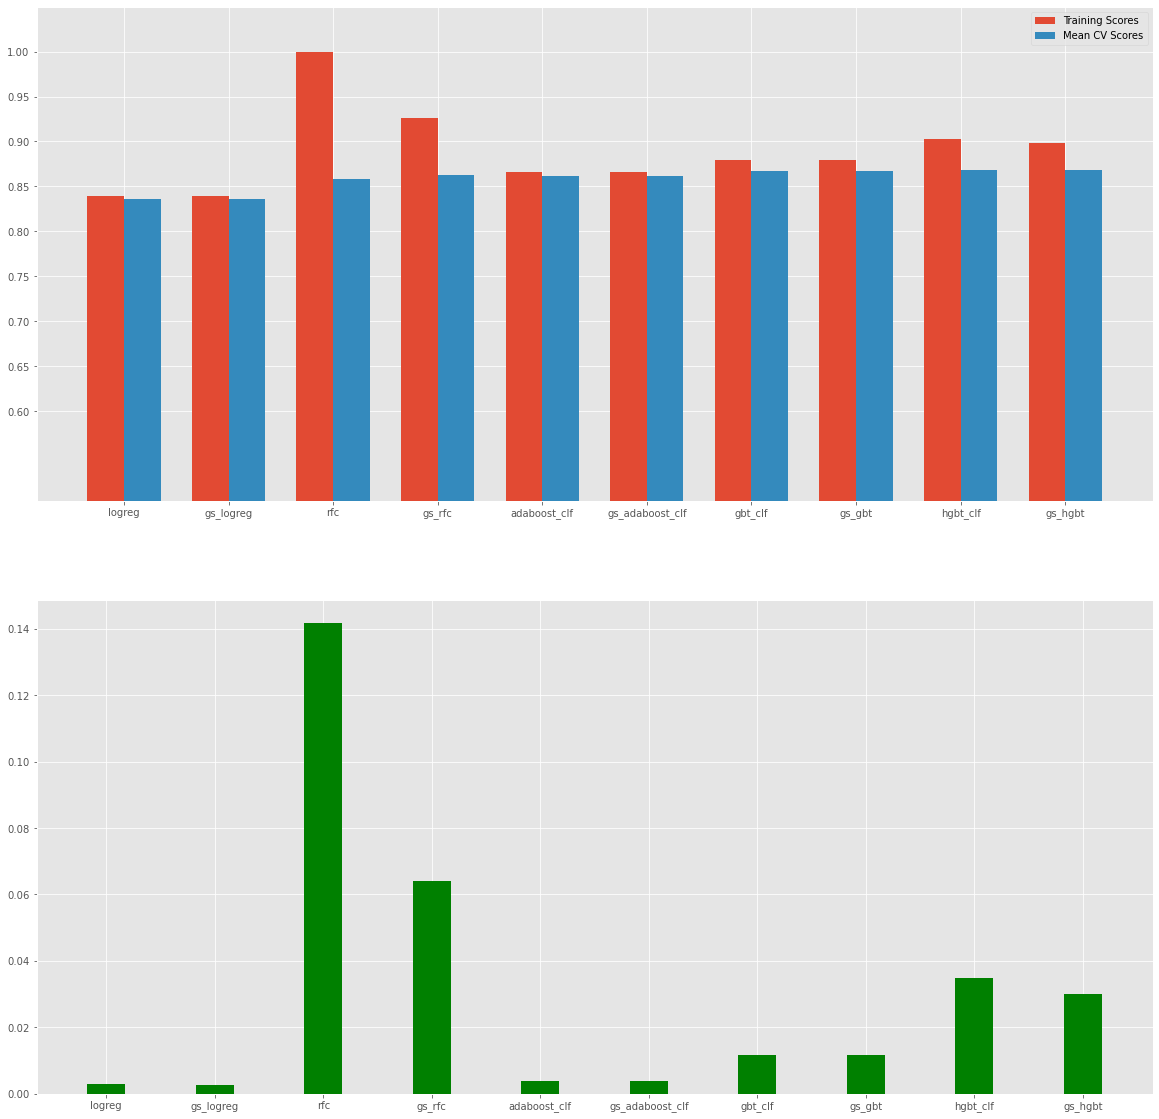

In [73]:
x = np.arange(len(model_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(nrows=2, figsize=(20, 20))
ax[0].bar(x - width/2, train_scores, label='Training Scores', width=width)
ax[0].bar(x + width/2, mean_cv_scores, label='Mean CV Scores', width=width)
ax[0].set_xticks(list(range(len(model_names))))
ax[0].set_xticklabels(model_names)
ax[0].set(ylim=(.5, 1.05))
ax[0].set_yticks(np.arange(.6,1.05,.05))
ax[0].legend()

ax[1].bar(model_names, deltas, color='green', width=width)

In [74]:
test_model_names = []
test_scores = []

for name, model in models_dict['models'].items():
    test_results = model_cv_results(model, X_test_scaled, y_test, cv=False)
    test_auc_score = test_results.loc['roc_auc']['score']
    test_model_names.append(name)
    test_scores.append(test_auc_score)

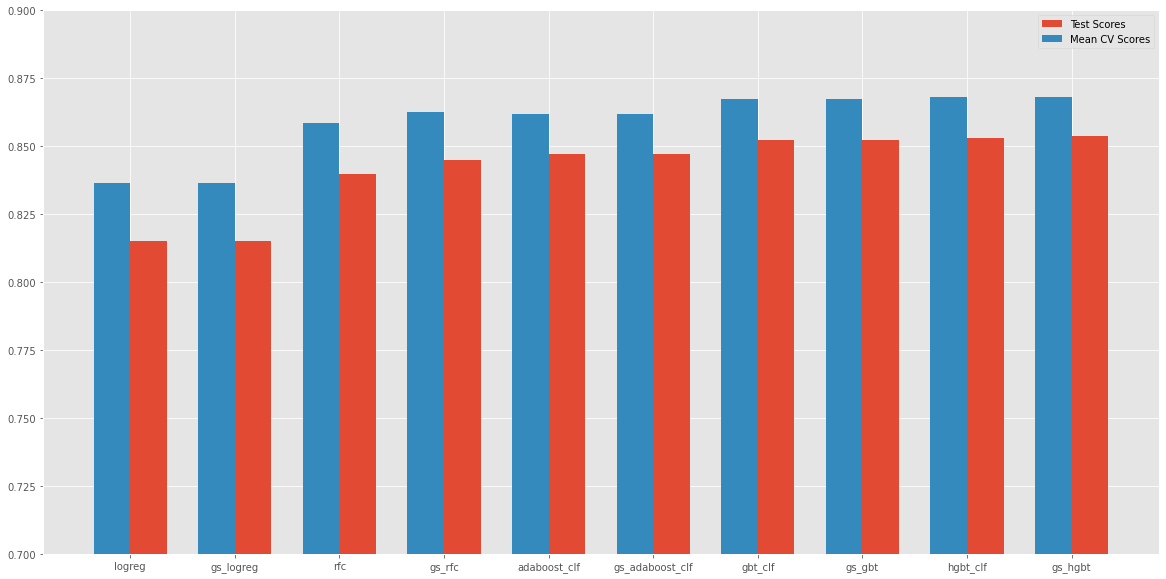

In [75]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(x + width/2, test_scores, width=width, label='Test Scores')
ax.bar(x - width/2, mean_cv_scores, label='Mean CV Scores', width=width)
ax.set_xticks(list(range(len(test_model_names))))
ax.set_xticklabels(test_model_names)
ax.set_ylim(.7, .9)
ax.legend()

In [76]:
### Feature importances

In [77]:
def plot_feature_importances(
    model, features=X_train_scaled.columns.tolist(), return_df=False, 
    cutoff=0, figsize=(5,13), regression=False
    ):

    """
    Plots the feature importances of a model. Can also return DataFrame of those importances
    if specified. 
    Defaults to work with tree based models. Set `regresssion` to True in order to plot
    the coefficients of regression models.
    """
    if regression:
        df = pd.DataFrame(
            zip(X_train_scaled.columns.tolist(), np.abs(model.coef_).tolist()[0]),
            columns=['feature', 'importance']
        ).sort_values(by='importance', ascending=True)[-cutoff:]
    else:
        df = pd.DataFrame(
            zip(X_train_scaled.columns.tolist(), model.feature_importances_.tolist()),
            columns=['feature', 'importance']
        ).sort_values(by='importance', ascending=True)[-cutoff:]

    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(y=df['feature'], width=df['importance'])
    if cutoff != 0:
        ax.set_title(f'Top {cutoff} features in the model')
    else:
        ax.set_title(f'Feature importances')
    plt.show();

    if return_df:
        return df[::-1]

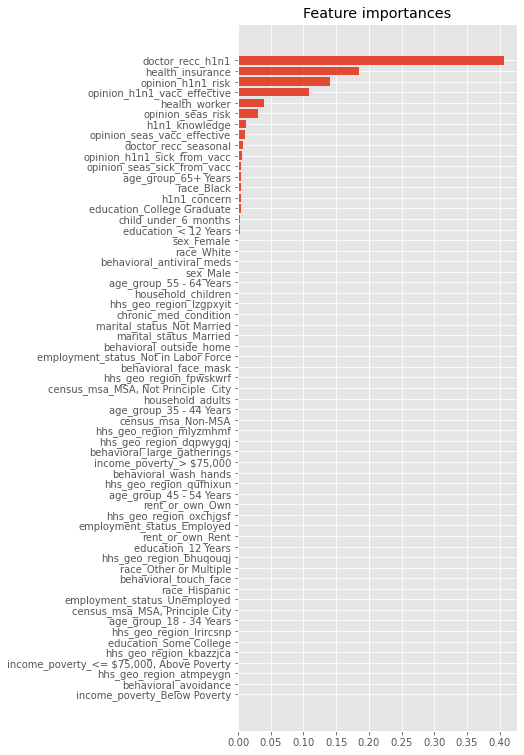

In [78]:
plot_feature_importances(gbt_clf)